In [1]:
'''
GCBC with point maze (with multi-goal + color state space)
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/data/pulkitag/misc/andipeng/anaconda3/envs/aligning-construals/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define simple MLP
class MLP(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod)
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)
    
def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

In [4]:
# Goal-conditioned Point Maze (with multi state + color)
import gym
import gym.wrappers

class PointEnvComplex(gym.Env):
    def __init__(self):
        self.pos = np.array([0., 0.])
        self.obj1_pos = np.array([1., 1.])
        self.obj1_color = np.array([0.])
        self.obj2_pos = np.array([1., 0.])
        self.obj2_color = np.array([0.])
        self.obj3_pos = np.array([-1., 0.])
        self.obj3_color = np.array([0.])
        self.goal_pos = np.array([-9., -9.])
        self.goal_color = np.array([0.])
        self.max_vel = 1.
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(14), np.inf * np.ones(14)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    # creates test env with defined goal locations + colors
    def reset(self, obj_angles=2*np.pi, obj_colors=4):
        self.pos = np.array([0., 0.])
        
        # obj1
        angle = np.random.uniform(0, obj_angles) # samples angle in radians (from range)
        pos = np.array([5*np.cos(angle), 5*np.sin(angle)]) # samples random goal pos
        color = np.array(random.randint(0, obj_colors-1)) # samples color from range
        self.obj1_pos = pos
        self.obj1_color = np.reshape(color, 1)

        # obj2
        angle = np.random.uniform(0, obj_angles) # samples angle in radians (from range)
        pos = np.array([5*np.cos(angle), 5*np.sin(angle)]) # samples random goal pos
        color = np.array(random.randint(0, obj_colors-1)) # samples color from range
        self.obj2_pos = pos
        self.obj2_color = np.reshape(color, 1)

        # obj3
        angle = np.random.uniform(0, obj_angles) # samples angle in radians (from range)
        pos = np.array([5*np.cos(angle), 5*np.sin(angle)]) # samples random goal pos
        color = np.array(random.randint(0, obj_colors-1)) # samples color from range
        self.obj3_pos = pos
        self.obj3_color = np.reshape(color, 1)

        # choose goal from random in objects
        goal_obj = random.randint(1, 3)
        if goal_obj == 1:
            goal_pos = self.obj1_pos
            goal_color = self.obj1_color
        elif goal_obj == 2:
            goal_pos = self.obj2_pos
            goal_color = self.obj2_color
        elif goal_obj == 3:
            goal_pos = self.obj3_pos
            goal_color = self.obj3_color
        self.goal_pos = goal_pos
        self.goal_color = goal_color
        return self.get_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.obj3_pos, self.obj3_color, self.goal_color]))
    
    def get_full_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.obj3_pos, self.obj3_color, self.goal_pos, self.goal_color]))

    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal_pos))
        return self.get_obs(), reward, False, {}
    
    def reward_fn(self, state):
        return -torch.linalg.norm((state - torch.Tensor(self.goal_pos).to(device)), dim=-1)

    def get_color(self, env_value):
        if env_value == 0:
            return 'red'
        elif env_value == 1:
            return 'blue'
        elif env_value == 2:
            return 'green'
        elif env_value == 3:
            return 'yellow'

/data/pulkitag/misc/andipeng/anaconda3/envs/aligning-construals/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def plot_env(env):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    plt.scatter([env.pos[0]],[env.pos[1]], marker='o', color='black', s=30) # plots agent
    plt.scatter([env.obj1_pos[0]],[env.obj1_pos[1]], marker='s', color=env.get_color(env.obj1_color[0]), s=30) # plots obj1
    plt.scatter([env.obj2_pos[0]],[env.obj2_pos[1]], marker='s', color=env.get_color(env.obj2_color[0]), s=30) # plots obj2
    plt.scatter([env.obj3_pos[0]],[env.obj3_pos[1]], marker='s', color=env.get_color(env.obj3_color[0]), s=30) # plots obj3
    plt.scatter([env.goal_pos[0]],[env.goal_pos[1]], marker='*', color=env.get_color(env.goal_color[0]), s=100) # plots goal

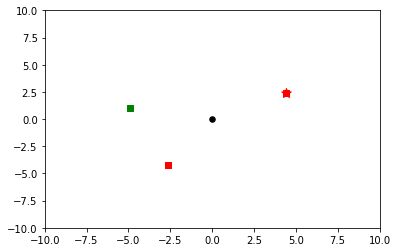

In [94]:
env = PointEnvComplex()
env.reset(obj_angles=2*np.pi, obj_colors=4)
plot_env(env)

In [95]:
# generates random trajs within specified constraints
def gen_trajs(env, num_trajs=1, obj_angles=2*np.pi, obj_colors=4):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    trajs = []
    for traj in range(num_trajs):
        env.reset(obj_angles, obj_colors)
        plot_env(env)
        # rolls out a trajectory towards the goal
        traj = {'obs': [],'acts': [], 'next_obs': []}
        delta_vector = env.goal_pos
        o = env.get_obs()
        for i in range(100):
            act = delta_vector * 0.01 # Go in direction between start and end
            no, r, d, _ = env.step(act)
            traj['obs'].append(o.copy())
            traj['acts'].append(act.copy())
            traj['next_obs'].append(no.copy())
            o = no
        traj['obs'] = np.array(traj['obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['next_obs'] = np.array(traj['next_obs'])
        
        plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
        
        trajs.append(traj)
    return trajs

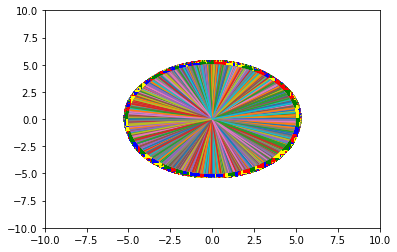

In [260]:
env = PointEnvComplex()
trajs = gen_trajs(env, num_trajs=5000, obj_angles=2*np.pi, obj_colors=4)

In [261]:
# Define the forward model
class Policy(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim, hidden_depth):
        super().__init__()
        self.trunk = mlp(obs_dim, hidden_dim, action_dim, hidden_depth)
        self.outputs = dict()
        self.apply(weight_init)

    def forward(self, obs):
        next_pred = self.trunk(obs)
        return next_pred

In [262]:
hidden_layer_size = 1000
hidden_depth = 3
horizon = 100
obs_size = env.observation_space.shape[0] - 2
act_size = env.action_space.shape[0]
policy = Policy(obs_size, act_size, hidden_layer_size, hidden_depth)
num_tasks = len(trajs)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

Policy(
  (trunk): Sequential(
    (0): Linear(in_features=12, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1000, out_features=2, bias=True)
  )
)

[1,     1] loss: 0.01239540
[2,     1] loss: 0.00133084
[3,     1] loss: 0.00123018
[4,     1] loss: 0.00089693
[5,     1] loss: 0.00066940
[6,     1] loss: 0.00077176
[7,     1] loss: 0.00059577
[8,     1] loss: 0.00056928
[9,     1] loss: 0.00033659
[10,     1] loss: 0.00046819
[11,     1] loss: 0.00048868
[12,     1] loss: 0.00037721
[13,     1] loss: 0.00041055
[14,     1] loss: 0.00035342
[15,     1] loss: 0.00044126
[16,     1] loss: 0.00038041
[17,     1] loss: 0.00032665
[18,     1] loss: 0.00038839
[19,     1] loss: 0.00037123
[20,     1] loss: 0.00051719
[21,     1] loss: 0.00048434
[22,     1] loss: 0.00038766
[23,     1] loss: 0.00029585
[24,     1] loss: 0.00020325
[25,     1] loss: 0.00019953
[26,     1] loss: 0.00017508
[27,     1] loss: 0.00041497
[28,     1] loss: 0.00024753
[29,     1] loss: 0.00025662
[30,     1] loss: 0.00022034
[31,     1] loss: 0.00021897
[32,     1] loss: 0.00028908
[33,     1] loss: 0.00015075
[34,     1] loss: 0.00027163
[35,     1] loss: 0.000

[278,     1] loss: 0.00015550
[279,     1] loss: 0.00014863
[280,     1] loss: 0.00019887
[281,     1] loss: 0.00025093
[282,     1] loss: 0.00020404
[283,     1] loss: 0.00011390
[284,     1] loss: 0.00011606
[285,     1] loss: 0.00007541
[286,     1] loss: 0.00006619
[287,     1] loss: 0.00011125
[288,     1] loss: 0.00010842
[289,     1] loss: 0.00010600
[290,     1] loss: 0.00008866
[291,     1] loss: 0.00007850
[292,     1] loss: 0.00008260
[293,     1] loss: 0.00012523
[294,     1] loss: 0.00008475
[295,     1] loss: 0.00010540
[296,     1] loss: 0.00007659
[297,     1] loss: 0.00023380
[298,     1] loss: 0.00011551
[299,     1] loss: 0.00013526
[300,     1] loss: 0.00011153
[301,     1] loss: 0.00006836
[302,     1] loss: 0.00007003
[303,     1] loss: 0.00006184
[304,     1] loss: 0.00009798
[305,     1] loss: 0.00013593
[306,     1] loss: 0.00011854
[307,     1] loss: 0.00011606
[308,     1] loss: 0.00009640
[309,     1] loss: 0.00009759
[310,     1] loss: 0.00023789
[311,     

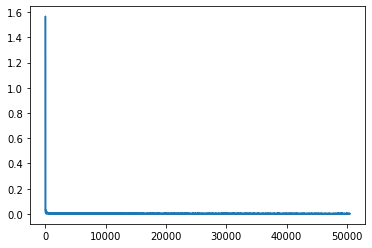

In [263]:
num_epochs = 500
batch_size = 50

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy.parameters()))

losses = []

idxs = np.array(range(len(trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t1_idx = np.random.randint(len(trajs), size=(batch_size,)) # Indices of traj
        t1_idx_pertraj = np.random.randint(100, size=(batch_size,))
        t1_states = np.concatenate([trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        t1_actions = np.concatenate([trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
   
        t1_states = torch.Tensor(t1_states).float().to(device)
        t1_actions = torch.Tensor(t1_actions).float().to(device)
        
        a1_pred = policy(t1_states.to(device)) # action prediction
        
        loss = torch.mean(torch.linalg.norm(a1_pred - t1_actions, dim=-1)) # supervised learning loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 10.))
            losses.append(running_loss/10.)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

[-2.946316   -4.03970569]
[2]


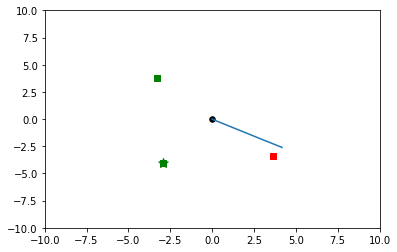

In [285]:
plt.xlim(-10, 10)
plt.ylim(-10, 10)
colors = sns.color_palette("hls", 10)

num_test_trajs = 1
# sets sampling for angles and colors
test_obj_angles = 2 * np.pi
test_obj_colors = 4

for i in range(num_test_trajs):
    env.reset(test_obj_angles, test_obj_colors)
    #env.goal_pos = np.array([trajs[0]['next_obs'][99][0], trajs[0]['next_obs'][99][1]])
    #env.goal_color = np.array([trajs[0]['next_obs'][99][-1]])
    #env.goal_color = np.array([3.])
    print(env.goal_pos)
    print(env.goal_color)
    plot_env(env)
    o = env.get_obs()
    traj = {'obs': [],'acts': [], 'next_obs': []}
    for i in range(100):
        t1s = torch.Tensor(o[None]).to(device)
        act = policy(t1s).cpu().detach().numpy()[0]
        no, r, d, _ = env.step(act)
        traj['obs'].append(o.copy())
        traj['acts'].append(act.copy())
        traj['next_obs'].append(no.copy())
        o = no.copy()
    traj['obs'] = np.array(traj['obs'])
    traj['acts'] = np.array(traj['acts'])
    traj['next_obs'] = np.array(traj['next_obs'])
    plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs
    
#plt.plot([-5, 5, 5, -5, -5], [5, 5,-5, -5, 5])